### MAIN CODE

Set up electron bubble and base matrices

In [120]:
tunnelFlag = False
#if true, solves for the tunneling case, otherwise solves for the non-tunnelling case

In [121]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.sparse.linalg as splin

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

def bubble_radius(theta, a_coeff):   
    ll = np.polynomial.legendre.Legendre(a_coeff)
    r = ll(np.cos(theta))
    #plt.polar(theta, r)
    return r

def plot_bubble(a_coeff_comp):
    theta_grid = np.linspace(0, 2*np.pi)
    a_coeff = np.zeros(2*len(a_coeff_comp)-1)
    a_coeff[0:len(a_coeff):2]= a_coeff_comp
    rad = bubble_radius(theta_grid, a_coeff)
    plt.polar(theta_grid, rad)
    
def sort_and_clean(E_el, psi_el, abs_tol=0, rel_tol = 0):
  # remove close duplicate values due to degeneracy / numerical error
    E_el = np.sort(E_el)
    E_el_clean = []    
    E_el_clean.append(E_el[0])
    idx = 0
    idx_list = []
    idx_list.append(idx)
    for i in range(1, len(E_el)):
        if (((E_el_clean[idx]+abs_tol)<E_el[i]) and (E_el_clean[idx]*(1+rel_tol)<E_el[i])):
            E_el_clean.append(E_el[i])
            idx +=1
            idx_list.append(i)
            
    psi_el_clean = psi_el[:,idx_list]
    return E_el_clean, psi_el_clean

In [122]:
def create_U_pol_base(n, r_grid, theta_grid):
    #we work using natural units
    dr = r_grid[1]-r_grid[0]
    d_theta = theta_grid[1]-theta_grid[0]
    N = len(theta_grid)
    
    U = np.zeros((N, N))
    r = r_grid[n-1]+dr/2.0
    #r_bubble = bubble_radius(theta_grid, a_coeff)
    
    for i in range(N):
        theta = theta_grid[i]
        
        #V = 1
        sin_j = np.sin(theta)
        sin_up = np.sin(theta+d_theta/2)
        sin_dn = np.sin(theta-d_theta/2)
        denr = r**2*sin_j*d_theta**2
        
        #if (r<r_bubble[i]):
        #    V = 0
            
        #U[i][i] = -2*(V+(sin_up+sin_dn)/(2*denr))
        U[i][i] = -(sin_up+sin_dn)/(denr)
        if (i!=0):
            U[i][i-1] = sin_dn/denr
        else:
            U[i][0] += sin_dn/denr
            
        if (i!=(N-1)):
            U[i][i+1] = sin_up/denr
        else:
            U[i][N-1] += sin_up/denr
            
    return U

def create_A_matrix_base(M, N, r_max):
    dr = r_max/(M-1)
    d_theta = np.pi/(N-1)
    r_grid = np.linspace(0, r_max, M)
    theta_grid = np.linspace(d_theta/2, np.pi-d_theta/2, N)
    
    mat_size = (M-2)*N
    A = sparse.eye(mat_size).tolil()
    Id = np.identity(N)
    
    for j in range(2, M):
        ro_lo = (j-2)*N
        U = dr**2*create_U_pol_base(j, r_grid, theta_grid)-2*Id
        A[ro_lo:ro_lo+N, ro_lo:ro_lo+N] = U
        
        if (j!=2):
            A[ro_lo:ro_lo+N, ro_lo-N:ro_lo] = Id
        if (j!=M-1):
            A[ro_lo:ro_lo+N, ro_lo+N:ro_lo+2*N] = Id
            
    return A

In [123]:
import os
def base_grid(M, N, R_max): 
    """
    This function loads matrices which are required for calculations
    If they do not exist, the matrices are created first and saved
    """
    filename = "opi_M"+str(M)+"_N"+str(N)+"_R"+str(int(R_max))
    base_mat =0
    # %cd CalcMatrices
    if (os.path.exists(filename+".npz")):
        base_mat = (sparse.load_npz(filename+".npz")).tolil()
        #print("Loaded")
    else:
        base_mat = create_A_matrix_base(M, N, R_max)
        sparse.save_npz(filename+".npz", base_mat.tocsr())
        print("Saved")
    # %cd ..
    return base_mat        

In [124]:
def create_full_A(M, N, R_max, a_coeff):
    r_max = R_max
    dr = r_max/(M-1)
    d_theta = np.pi/(N-1)
    r_grid = np.linspace(0, r_max, M)
    theta_grid = np.linspace(d_theta/2, np.pi-d_theta/2, N)
    r_bubble = bubble_radius(theta_grid, a_coeff)    
    A = base_grid(M, N, R_max)
    for j in range(2, M):
        for i in range(N):
            idx = (j-2)*N+i
            r = r_grid[j-1]+dr/2.0
            theta = theta_grid[i]            
            #V = 10000
            V= 0.131 if tunnelFlag else 131 #1 ev or 1000 eV in simulation units respectively
            if (r<r_bubble[i]):
                V = 0            
            A[idx, idx] = A[idx, idx]-2*V*dr**2           
    return A

def find_lowest_evals_psi(M, N, R_max, a_coeff, n_eigs=5):
    """
    Schrodinger equation solver. See Saraswat - Bachelor's thesis for calculation and benchmarking
    """
    A = create_full_A(M, N, R_max, a_coeff)
    dr = R_max/(M-1)
    sA = -A/(2*dr*dr)
    e_vals, e_vecs = splin.eigs(sA, k = n_eigs, which='SM')    
    return np.real(e_vals), np.real(e_vecs)

def find_lowest_evals_gridadapt(M, N, a_coeff, n_eigs = 5):
    theta_grid = np.linspace(0, np.pi)
    r_maxb = np.max(bubble_radius(theta_grid, a_coeff))
    R_max = np.ceil(r_maxb)+10
    return find_lowest_evals_psi(M, N, R_max, a_coeff, n_eigs)

def find_lowest_evals_guess(M, N, a_coeff, E_guess, psi_guess):
    """
    Solve for eigensystem around a guessed value
    """
    theta_grid = np.linspace(0, np.pi)
    r_maxb = np.max(bubble_radius(theta_grid, a_coeff))
    R_max = np.ceil(r_maxb)+10
    
    A = create_full_A(M, N, R_max, a_coeff)
    dr = R_max/(M-1)
    sA = -A/(2*dr*dr)
    e_vals, e_vecs = splin.eigs(sA, k=1, sigma=E_guess, v0=psi_guess)    
    return np.real(e_vals), np.real(e_vecs)   

Calculate Energy values of the electron bubble in different ways

In [125]:
#Chosen units: hbar=1 ; m_el=1; length in Angstroms
tension_coeff = 2.79313e-6 
bar1 = 8.191e-8

def Volume(a_coeff, debug=0):
    theta_grid = np.linspace(0, np.pi, 1000)
    r_grid = bubble_radius(theta_grid, a_coeff)
    d_theta = theta_grid[1]-theta_grid[0]
    vol =0
    for i in range(len(theta_grid)):
        vol+= 2*np.pi/3*(r_grid[i]**3)*np.sin(theta_grid[i])*d_theta
    if (debug == 2):
        print("Volume of Bubble = "+str(vol))
    return vol

def Area(a_coeff, debug=0):
    theta_grid = np.linspace(0, np.pi, 1000)
    r_grid = bubble_radius(theta_grid, a_coeff)
    d_theta = theta_grid[1]-theta_grid[0]
    area =0
    for i in range(len(theta_grid)):
        area+= 2*np.pi*(r_grid[i]**2)*np.sin(theta_grid[i])*d_theta
    if (debug == 2):
        print("Surface Area of Bubble = "+str(area))
    return area

def LengthWaistVolume(a_coeff_comp):
    a_coeff = np.zeros(2*len(a_coeff_comp)-1)
    a_coeff[0:len(a_coeff):2]= a_coeff_comp
    bubLen = bubble_radius(0, a_coeff)
    bubWaist = bubble_radius(np.pi/2, a_coeff)
    bubVol = Volume(a_coeff)
    return bubLen, bubWaist, bubVol

In [126]:
#Calculate Energies for the N-th level
def Energy(n_level, M, N, a_coeff_comp, PP = 0, debug=0):
    """
    This function calculates the total energy of a bubble for a given level, using Energy_levels
    Returns : BubbleEnergy    (in mHartree)
              BestWavefunction(MN array)
              ErrorFlag       (Bubble allowed?)
    """
    
    try:
        E_list, psi_list, err_flag = Energy_levels(0, n_level, M, N, a_coeff_comp, PP, debug)
        if (debug == 2):
            print(E_list)
            print("Chosen Energy Level = "+str(E_list[-1]))
        return E_list[-1], psi_list[:,-1], err_flag
    except:
        print("Error")
        return 1.0e5, np.zeros(M*N), 1

#Calculate Energies for the first N levels
def Energy_levels(n_lo, n_hi, M, N, a_coeff_comp, PP = 0, debug=0):
    """
    This function calculates the total energy of a bubble for multiple levels
    Returns : BubbleEnergy    (in mHartree)
              BestWavefunction(MN array)
              ErrorFlag       (Bubble allowed?)
    """
    
    if (debug ==2):
        print("Currently solving Shape: "+str(a_coeff_comp))
        
    theta_grid = np.linspace(0, np.pi)    
    
    a_coeff = np.zeros(2*len(a_coeff_comp)-1)
    a_coeff[0:len(a_coeff):2]= a_coeff_comp
    
    if (np.min(bubble_radius(theta_grid, a_coeff))<0):
        print("Bad bubble")
        return 1.0e5, np.zeros(M*N), 1 
        #we return a value of 100 natural units, which is a reasonable scale too
    
    E_el, psi_el = find_lowest_evals_gridadapt(M, N, a_coeff)
    E_el, psi_el = sort_and_clean(E_el, psi_el)
    if (debug ==2):
        print("Energy Levels = "+str(E_el))    
    
    E_el = E_el[n_lo:n_hi] #n_level starts from 0
    psi_el = psi_el[:,n_lo:n_hi]
    
    E = E_el + tension_coeff*Area(a_coeff, debug)+PP*bar1*Volume(a_coeff, debug)
    if (debug ==2):
        print("Final Energy = "+str(E*1000)+" mHartree \n _______________________ \n") 
    return E*1000, psi_el, 0

#Calculate a single energy level around a guessed energy eigenvalue and eigenvector
def EnergyGuess(M, N, a_coeff_comp, E_guess, psi_guess, PP = 0, debug=0):
    """
    This function calculates the total energy of a bubble closest to a starting guess
    Returns : BubbleEnergy    (in mHartree)
              ElectronEnergy  (in Hartree)
              BestWavefunction(MN array)
              ErrorFlag       (Bubble allowed?)
    """
    
    if (debug ==2):
        print("Currently solving Shape: "+str(a_coeff_comp))
        
    theta_grid = np.linspace(0, np.pi)    
    
    a_coeff = np.zeros(2*len(a_coeff_comp)-1)
    a_coeff[0:len(a_coeff):2]= a_coeff_comp
    
    if (np.min(bubble_radius(theta_grid, a_coeff))<0):
        print("Bad bubble")
        return 1.0e5, E_guess, psi_guess, 1         
    
    E_el, psi_el = find_lowest_evals_guess(M, N, a_coeff, E_guess, psi_guess)
    E_el = E_el[0]
    psi_el = psi_el[:, 0]
    
    if (debug ==2):
        print("Energy Level = "+str(E_el))    
        
    E = E_el + tension_coeff*Area(a_coeff, debug)+PP*bar1*Volume(a_coeff, debug)
    if (debug ==2):
        print("Final Energy = "+str(E*1000)+" mHartree \n _______________________ \n") 
    return E*1000, E_el, psi_el, 0

In [127]:
#Gradient descent for the energy - shortcut doesn't work very well because it switches energy levels
def aN_Gradient_SingleGuess(a_trial, E_test, psi_test, PP=0, N_coeffs=0, da_start=0, debug=0):
    """
    This function returns a (N+1) dimensional matrix, which stores the gradient for dimension N, and the last index
    stores the value of energy at the test point
    """
    
    if (N_coeffs==0):
        N_coeffs = len(a_trial)
        
    if (np.all(da_start == 0)):
        da_start = 2*np.ones(N_coeffs) 
        
    ID_matrix = np.eye(N_coeffs);
    E_out = E_test
    psi_out = psi_test
    err_flag = 0
    
    grad_list = np.zeros(N_coeffs+1)   
    E_out, E_test, psi_guess, err_flag = EnergyGuess(M, N, a_trial, E_test, psi_test, PP, debug=debug)
    grad_list[-1] = E_out
    #print("E = " + str(grad_list[-1]))
    
    for k in range(N_coeffs):
        index = ID_matrix[k,:]      
        
        a_up = a_trial + index*da_start
        a_dn = a_trial - index*da_start
        E_up, E_up_el, psi_up, err_up = EnergyGuess(M, N, a_up, E_test, psi_test, PP, debug=debug)
        E_dn, E_dn_el, psi_dn, err_dn = EnergyGuess(M, N, a_dn, E_test, psi_test, PP, debug=debug)
        
        if ((E_up>grad_list[-1]) and (E_dn > grad_list[-1])):
            #minimum
            grad_list[k] = 0
            #print("Local minimum encountered at grid size")
        elif ((err_up == 1) or (err_dn == 1)):
            #illegal value on one side, choose smaller coefficient and continue
            print("Wall condition encountered")
            grad_list[k] = 0
            err_flag = 1
        else:                
            grad_list[k] = (E_up - E_dn)/(2*da_start[k]) 
    
    return grad_list, E_test, psi_out, err_flag

def findAN_gradDesc_SingleGuess(n_level, a_guess, PP=0, n_iter_max = 100, a_tol = 1e-3, da_start = 0, debug=0, 
                    learning_rate_in = 0.2):
    """
    This function does a basic gradient descent through space, with a fixed learning rate
    Needs M and N predefined, or uses the default values set in Energy
    """
    
    N_coeffs = len(a_guess)
    expl_flag = False    
    if (np.all(da_start == 0)):
        da_start = 0.4*np.ones(N_coeffs)    
    a_start = a_guess    
    a_path = np.zeros([n_iter_max+1, N_coeffs])
    a_path[0, :] = a_start
    E_path = np.zeros(n_iter_max+1)     
    
    #first, we need to find the initial guess that we are going to perturb, using the full solver
    E_guess, psi_guess, err_flag = Energy(n_level, M, N, a_guess, PP, debug=debug)
    if (err_flag == 1):
        print("Crappy starting value - exiting")
        return a_start, 100, psi_guess, 1
    a_coeff = np.zeros(2*len(a_guess)-1)
    a_coeff[0:len(a_coeff):2]= a_guess
    E_el_guess = E_guess/1000 - tension_coeff*Area(a_coeff, debug)-PP*bar1*Volume(a_coeff, debug)
    
    a_grad_mem = 0; learning_flag = True; #for gradient descent
    
    #try:
    for i in range(n_iter_max):
        a_grad, E_el_guess, psi_guess, err_flag = aN_Gradient_SingleGuess(a_start, E_el_guess, psi_guess, PP, \
              N_coeffs=N_coeffs, da_start = da_start, debug=debug)        
        if (err_flag == 1):
            print("Error value encountered.")
            return a_path, E_path, psi_guess, expl_flag
        
        if (i>=1 and (a_grad[-1]-E_path[i-1]>0.001)):
            #somehow we have switched to the wrong electronic state: REDO
            i-=1
            E_guess, psi_guess, err_flag = Energy(n_level, M, N, a_start, PP, debug=debug)
            a_coeff = np.zeros(2*len(a_start)-1)
            a_coeff[0:len(a_coeff):2]= a_start
            E_el_guess = E_guess/1000 - tension_coeff*Area(a_coeff, debug)-PP*bar1*Volume(a_coeff, debug)
            learning_flag = False
            continue
        else:
            E_path[i] = a_grad[-1]
            
        a_grad_trim = a_grad[:-1]
        
        if (learning_flag):
            #Barzlai-Borwein method
            learning_rate = np.sum((a_path[i]-a_path[i-1])*(a_grad_trim-a_grad_mem))
            learning_rate = np.abs(learning_rate/(np.linalg.norm(a_grad_trim-a_grad_mem)**2))
            learning_rate = min(learning_rate, 4)
        else:
            learning_rate = learning_rate_in
            
        if (debug == 1):
            print("Learning rate = "+str(learning_rate))
        a_start = a_start - learning_rate*a_grad_trim#np.sign(a_grad_trim)*da_start
        a_path[i+1, :] = a_start
        da_start[a_grad_trim == 0]/=2
        a_grad_mem = a_grad_trim
        
        #special case to fix the infinite loop we kept finding
        if (np.all(a_start - a_path[i-1, :] == 0)):
            a_start = 0.5*(a_path[i-1, :] + a_path[i, :])

        if(debug == 1):
            print("a_grad=: " +str(a_grad_trim))
            
        print("a= : " +str(a_path[i, :]) + ",  E = " + str(E_path[i]))

        if ( learning_rate < a_tol): #or (np.amax(a_grad_trim) < a_tol)
            print("\n CONVERGED TO : " +str(a_start) +" in " + str(i) + " iterations. ")
            a_path = a_path[:(i+1)]
            a_start = a_path[i, :]
            break

        if (a_start[0]>100):
            #definitely out of bounds
            print("Bubble exploded - a0 too large")
            return a_path, E_path, psi_guess, True
        #print("*****************************************")

    a_path[-1] = a_start
    E_path[-1], psi_guess, expl_flag = Energy(n_level, M, N, a_start, PP)
    
    if (np.abs(E_path[-1] - E_path[-2])>0.1):
        expl_flag = True
    #except:
    #print("Error happened.")
    #expl_flag = True
        
    if (i >= n_iter_max-1):
        print("Did not converge.")
        expl_flag = 1
        
    print("==============    P = " + str(PP) + "  done =====================")
    #print("===================================================================\n")
    return a_path, E_path, psi_guess, expl_flag

In [128]:
#Gradient descent for the energy - unsmart but works
def aN_Gradient(n_level, a_trial, E_test, psi_test, PP=0, N_coeffs=0, da_start=0, debug=0):
    """
    This function returns a (N+1) dimensional matrix, which stores the gradient for dimension N, and the last index
    stores the value of energy at the test point
    """
    
    if (N_coeffs==0):
        N_coeffs = len(a_trial)
        
    if (np.all(da_start == 0)):
        da_start = 2*np.ones(N_coeffs) 
        
    ID_matrix = np.eye(N_coeffs);
    err_flag = 0
    
    grad_list = np.zeros(N_coeffs+1)   
    E_test, psi_out, err_flag = Energy(n_level, M, N, a_trial, PP=PP, debug=debug)
    grad_list[-1] = E_test
    #print("E = " + str(grad_list[-1]))
    
    for k in range(N_coeffs):
        index = ID_matrix[k,:]      
        
        a_up = a_trial + index*da_start
        a_dn = a_trial - index*da_start
        
        E_up, psi_up, err_up = Energy(n_level, M, N, a_up, PP, debug=debug)
        E_dn, psi_dn, err_dn = Energy(n_level, M, N, a_dn, PP, debug=debug)
        
        if ((E_up>grad_list[-1]) and (E_dn > grad_list[-1])):
            #minimum
            grad_list[k] = 0
            #print("Local minimum encountered at grid size")
        elif ((err_up == 1) or (err_dn == 1)):
            #illegal value on one side, choose smaller coefficient and continue
            print("Wall condition encountered")
            grad_list[k] = 0
            err_flag = 1
        else:                
            grad_list[k] = (E_up - E_dn)/(2*da_start[k]) 
    
    return grad_list, psi_out, err_flag

def findAN_gradDesc(n_level, a_guess, PP=0, n_iter_max = 40, a_tol = 1e-3, da_start = 0, debug=0, 
                    learning_rate_in = 0.2, term_cond = 1):
    """
    This function does a gradient descent through aN space
    Needs M and N predefined, or uses the default values set in Energy
    returns: a_path, E_path, psi_guess, expl_flag
    term_cond: terminate_condition (set to 1 for low learning rate, 0 for fixed iteration number)
    """
    
    N_coeffs = len(a_guess)
    expl_flag = False    
    if (np.all(da_start == 0)):
        da_start = 4*np.ones(N_coeffs)    
    a_start = a_guess    
    a_path = np.zeros([n_iter_max+1, N_coeffs])
    a_path[0, :] = a_start
    E_path = np.zeros(n_iter_max+1)     
    
    #first, we need to find the initial guess that we are going to perturb, using the full solver
    E_guess, psi_guess, err_flag = Energy(n_level, M, N, a_guess, PP, debug=debug)
    if (err_flag == 1):
        print("Crappy starting value - exiting")
        return a_start, 100, psi_guess, 1
    
    a_grad_mem = 0;
    
    #try:
    for i in range(n_iter_max):
        a_grad, psi_guess, err_flag = aN_Gradient(n_level, a_start, E_guess, psi_guess, PP, \
              N_coeffs=N_coeffs, da_start = da_start, debug=debug)        
        
        if (err_flag == 1):
            print("Error value encountered.")
            return a_path, E_path, psi_guess, expl_flag        
        
        E_path[i] = a_grad[-1]            
        a_grad_trim = a_grad[:-1]
        
        if (i>=1):
            #Barzlai-Borwein method
            learning_rate = np.sum((a_path[i]-a_path[i-1])*(a_grad_trim-a_grad_mem))
            learning_rate = np.abs(learning_rate/(np.linalg.norm(a_grad_trim-a_grad_mem)**2))
            learning_rate = min(learning_rate, 4)
        else:
            learning_rate = learning_rate_in
            
        if (debug == 1):
            print("Learning rate = "+str(learning_rate))
        a_start = a_start - learning_rate*a_grad_trim#np.sign(a_grad_trim)*da_start
        a_path[i+1, :] = a_start
        da_start[a_grad_trim == 0]/=2
        a_grad_mem = a_grad_trim
        
        #special case to fix the infinite loop we kept finding
        if (np.all(a_start - a_path[i-1, :] == 0)):
            a_start = 0.5*(a_path[i-1, :] + a_path[i, :])

        if(debug == 1):
            print("a_grad=: " +str(a_grad_trim))
            
        print("a= : " +str(a_path[i, :]) + ",  E = " + str(E_path[i]))

        if (term_cond==1 and learning_rate < a_tol): #or (np.amax(a_grad_trim) < a_tol)
            print("\n CONVERGED TO : " +str(a_start) +" in " + str(i) + " iterations. ")
            a_path = a_path[:(i+1)]
            a_start = a_path[i, :]
            break

        if (a_start[0]>100):
            #definitely out of bounds
            print("Bubble exploded - a0 too large")
            return a_path, E_path, psi_guess, True
        #print("*****************************************")

    a_path[-1] = a_start
    E_path[-1] = a_grad[-1]
        
    if (i >= n_iter_max-1 and term_cond != 0): #did not terminate if we had a condition
        print("Did not converge.")
        expl_flag = 1
        
    print("==============    P = " + str(PP) + "  done =====================")
    print("==================================================================\n")
    return a_path, E_path, psi_guess, expl_flag

In [129]:
#this module plots the wavefunction and the bubble. Ignore the edges of the plot, they are extrapolations

from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate
from matplotlib import cm

def convert_to_cartesian(e_vec, r_grid, theta_grid):
    M = len(r_grid)
    N = len(theta_grid)
    
    x = np.zeros((M-2)*N)
    y = np.zeros((M-2)*N)
    z = np.zeros((M-2)*N)
    
    i = 0
    for col in range(M-2):
        for row in range(N):
            r = r_grid[col+1]
            theta = theta_grid[row]
            x[i] = r*np.cos(theta)
            y[i] = r*np.sin(theta)
            z[i] = e_vec[i]
            i+=1
            
    return x, y, z

def plot_wavefunction(a_coeff_comp, psi_el, M, N):
    d_theta = np.pi/(N-1)
    theta_grid = np.linspace(d_theta/2, np.pi-d_theta/2, N)
    a_coeff = np.zeros(2*len(a_coeff_comp)-1)
    a_coeff[0:len(a_coeff):2]= a_coeff_comp
    bub_rad = bubble_radius(theta_grid, a_coeff)
    R_max = np.ceil(np.max(bub_rad))+5
    dr = R_max/(M-1)
    r_grid = np.linspace(0, R_max, M)
    
    x, y, z = convert_to_cartesian(psi_el, r_grid, theta_grid)
    
    xx = []
    yy = []
    zz = []
    xx.append(x)
    xx.append(x)
    yy.append(y)
    yy.append(-y)
    zz.append(z)
    zz.append(z)
    x = np.array(xx)
    y = np.array(yy)
    z = np.array(zz)
    
    #xnew, ynew = np.mgrid[-R_max:R_max:100j, -R_max:R_max:100j]
    #rbf = interpolate.Rbf(x, y, z, epsilon=2)
    #znew = rbf(xnew, ynew)
    
    #plt.pcolor(xnew, ynew, znew, cmap=cm.jet)
    plt.scatter(x, y, 10, z, cmap=cm.jet)
    plt.colorbar()
    #plt.polar(theta_grid, bub_rad)
    #fig = plt.figure()
    #ax = fig.add_subplot(111, projection='3d')
    #ax.plot_surface(xnew, ynew, znew, cmap = plt.cm.YlGnBu_r)
    xbub = bub_rad*np.cos(theta_grid)
    ybub = bub_rad*np.sin(theta_grid)
    plt.plot(xbub, ybub, linewidth=3, color='k')
    plt.plot(xbub, -ybub, linewidth=3, color='k')


In [130]:
#do multiple gradient descents - careful to not switch states
def doNNGradDescents(n_level,a_guess, PP=0, NN=4, n_iter_max = 80, a_tol = 5e-3, da_start = 0, debug=0, 
                    learning_rate = 1):
    
    N_coeffs = len(a_guess)
    a_bigpath = np.zeros([NN, N_coeffs])
    E_bigpath = np.zeros(NN)    
    psi_bigpath = np.zeros([NN, (M-2)*N])
    if (np.all(da_start == 0)):
        da_start = 0.4*np.ones(N_coeffs)
    
    da_start0 = np.copy(da_start)
    
    for i in range(NN):
        a_path, E_path, psi_guess, expl_flag = findAN_gradDesc_SingleGuess(n_level, a_guess, PP, n_iter_max, a_tol, da_start, debug, learning_rate)
        
        a_guess = np.around(a_path[-1], decimals=3)
        print("\n .......................................................... \n .......................................................... \n")
        #plot_wavefunction(a_path[-1], psi_guess, M, N)
        
        a_bigpath[i, :] = a_guess
        E_bigpath[i] = E_path[-1]
        psi_bigpath[i, :] = psi_guess
        da_start = np.copy(da_start0)
        
        if(expl_flag == 1):
            break
        
    return a_bigpath, E_bigpath, psi_bigpath, expl_flag

In [131]:
#choose grid size
M = 81 
N = 50

### FIND ENERGY AND WAVEFUNCTION

In [113]:
#solve a specific energy level and plot the wavefunction

a_coeff_comp = [40, 5, -1,  0.]
E_list, psi_list, flag = Energy_levels(0, 3, 81, 50, a_coeff_comp, PP=0, debug=1)

61.574577178410344

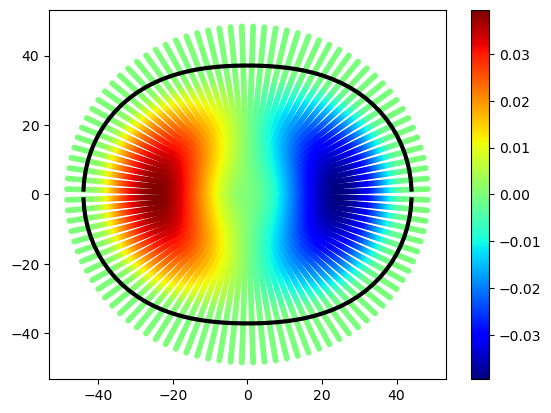

In [114]:
k = 1
plot_wavefunction(a_coeff_comp, psi_list[:, k], 81, 50)
E_list[k]

### FIND LOWEST ENERGY SHAPE

In [132]:
[a_path, E_path, psi_guess, expl_flag] = findAN_gradDesc(2, np.array([40,5,-1,0]), PP = -1.5, da_start = 2*np.ones(4), a_tol = 1e-3, debug=0, learning_rate_in=0.3)

a= : [40.  5. -1.  0.],  E = 28.744373855836074
a= : [39.982  5.048 -1.002  0.001],  E = 28.710978348919795
a= : [39.979  5.056 -1.003  0.001],  E = 28.709715047445634
a= : [39.766  5.708 -1.05   0.001],  E = 28.61469638308456
a= : [39.761  5.72  -1.051  0.002],  E = 28.607095306819875
a= : [39.473  6.362 -1.052  0.042],  E = 28.47369895987665
a= : [39.169  7.042 -1.073  0.042],  E = 28.350565569446353
a= : [38.93   7.515 -1.075  0.143],  E = 28.22170531249179
a= : [38.891  7.587 -1.075  0.131],  E = 28.201012509814245
a= : [38.779  7.788 -1.077  0.086],  E = 28.145657588988094
a= : [38.367  8.504 -1.079 -0.076],  E = 27.992434602455862
a= : [37.875  9.238 -1.122 -0.37 ],  E = 27.800083921448365
a= : [37.828  9.307 -1.122 -0.38 ],  E = 27.78617504087658
a= : [37.823  9.315 -1.122 -0.38 ],  E = 27.784865177632497
a= : [37.286 10.118 -1.166 -0.391],  E = 27.563504103611848
a= : [37.264 10.148 -1.167 -0.379],  E = 27.550043837660205
a= : [37.201 10.232 -1.168 -0.356],  E = 27.511025078217

a = [31.699 16.648 -1.768 -0.229] ,  E = 25.099710365455206  (expl_flag = 1)
Length = 46.35009404172147, Waist =22.783905473346177, Volume = 156417.61176437268


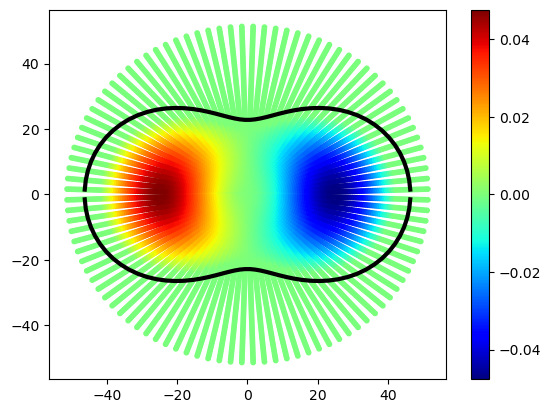

In [133]:
#look at the wavefunction, energy, and dimensions of the bubble
plot_wavefunction(a_path[-1], psi_guess, M, N)
print("a = " + str(a_path[-1]) + " ,  E = " + str(E_path[-1]) + "  (expl_flag = "+str(expl_flag)+")")
bubLen, bubWaist, bubVol = LengthWaistVolume(a_path[-1])

print("Length = "+str(bubLen) + ", Waist ="+str(bubWaist)+", Volume = "+str(bubVol))

In [89]:
#dodgyA = np.array([16.234,21.914,1.601,-0.271])
#dodgyE = 26.509
#a_fin_list_notunn[1, :] = dodgyA
#E_fin_list_notunn[1] = dodgyE
#len_list_notunn[1], waist_list_notunn[1], vol_list_notunn[1] = LengthWaistVolume(dodgyA)

In [119]:
#do a search over pressures for the 1p state with the 1p spherical guess

n_P_pts = 12
P_list = np.linspace(-1.5, -1.9, n_P_pts)

psi_guess_list = []
a_fin_list = np.zeros((n_P_pts, 4))
E_fin_list = np.zeros(n_P_pts)
len_list = np.zeros(n_P_pts)
waist_list = np.zeros(n_P_pts)
vol_list = np.zeros(n_P_pts)

expl_flag_list = np.zeros(n_P_pts, dtype=bool)

for i in range(n_P_pts):
    #sphericalRadius = 23.16 -536.24*P_list[i]/(68.2+115.79*P_list[i])
    [a_path, E_path, psi_guess, expl_flag] = findAN_gradDesc(2, np.array([40, 5, -1, 0]), PP = P_list[i], 
                                      da_start = 2*np.ones(4), a_tol = 1e-3, debug=0, learning_rate_in=0.3)
    a_fin_list[i, :] = a_path[-1, :]
    psi_guess_list.append(psi_guess)
    E_fin_list[i] = E_path[-1]
    len_list[i], waist_list[i], vol_list[i] = LengthWaistVolume(a_path[-1])
    expl_flag_list[i] = expl_flag

a= : [40.  5. -1.  0.],  E = 28.319308477069004
a= : [39.972  5.045 -1.002  0.001],  E = 28.29518289922516
a= : [39.724  5.473 -1.034  0.014],  E = 28.211301334873983
a= : [39.337  6.07  -1.06   0.018],  E = 28.091191213642926
a= : [38.89   6.689 -1.097  0.039],  E = 27.938047302211583
a= : [38.382  7.318 -1.138  0.075],  E = 27.76709601765282
a= : [37.805  8.001 -1.164  0.102],  E = 27.550004102700527
a= : [37.109  8.689 -1.218  0.127],  E = 27.285889631897174
a= : [36.373  9.39  -1.237  0.127],  E = 27.031565471938183
a= : [35.579 10.151 -1.237  0.17 ],  E = 26.710807036716723
a= : [34.659 10.913 -1.261  0.204],  E = 26.35128782999402
a= : [33.705 11.692 -1.269  0.204],  E = 25.99183483973811
a= : [32.688 12.471 -1.24   0.253],  E = 25.54640088840088
a= : [31.638 13.283 -1.24   0.238],  E = 25.124512764359572
a= : [30.59  14.077 -1.171  0.201],  E = 24.662527084484246
a= : [29.559 14.932 -1.113  0.201],  E = 24.194198078086885
a= : [28.497 15.797 -0.982  0.201],  E = 23.7433224970028

a= : [40.  5. -1.  0.],  E = 24.288366816263196
a= : [40.063  5.049 -1.002  0.001],  E = 24.265540452214797
a= : [40.272  5.203 -1.008  0.001],  E = 24.18991296747318
a= : [41.158  5.846 -1.013  0.047],  E = 23.863643829408886
a= : [42.247  6.513 -1.032  0.061],  E = 23.414327668552588
a= : [43.604  7.234 -1.065  0.061],  E = 22.77742640381819
a= : [45.329  7.973 -1.065  0.1  ],  E = 21.78343502853985
a= : [47.569  8.752 -1.073  0.097],  E = 20.166190693452617
a= : [50.56   9.638 -1.12   0.097],  E = 17.33738872379878
a= : [54.694 10.646 -1.144  0.018],  E = 11.934803253580359
a= : [60.575 11.83  -1.165  0.057],  E = 0.7861001736029494
Saved
a= : [69.444 13.291 -1.202  0.023],  E = -25.333377803071127
a= : [83.781 15.224 -1.223  0.036],  E = -96.97085238113132
Bubble exploded - a0 too large
a= : [40.  5. -1.  0.],  E = 23.482178484108225
a= : [40.081  5.05  -1.002  0.001],  E = 23.449547867887244
a= : [40.613  5.364 -1.02   0.011],  E = 23.241552130267767
a= : [41.833  6.003 -1.058  0.

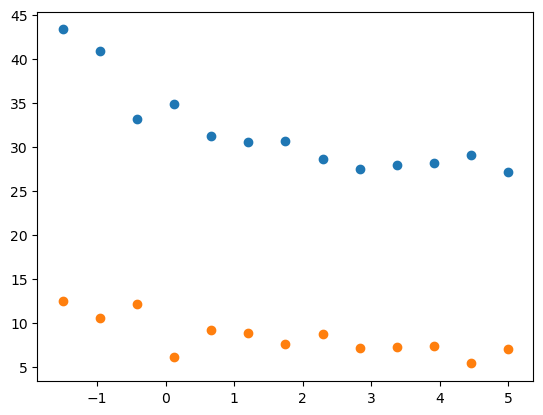

In [39]:
plt.scatter(P_list, len_list)
plt.scatter(P_list, waist_list)

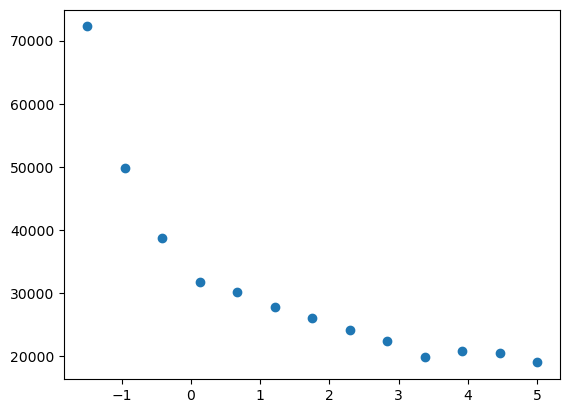

In [40]:
plt.scatter(P_list, vol_list)

In [41]:
np.savez('CloseStart_tunn_result', P_list, psi_guess_list, a_fin_list, E_fin_list, len_list, waist_list, vol_list)

In [54]:
with np.load('CloseStart_tunn_result.npz') as data:
    P_list_tunn = data['arr_0']
    #psi_guess_list_tunn = data['arr_1']
    a_fin_list_tunn = data['arr_2']
    E_fin_list_tunn = data['arr_3']
    len_list_tunn = data['arr_4']
    waist_list_tunn = data['arr_5']
    vol_list_tunn = data['arr_6']

In [55]:
with np.load('CloseStart_base_result.npz') as data:
    P_list_notunn = data['arr_0']
    #psi_guess_nolist_tunn = data['arr_1']
    a_fin_list_notunn = data['arr_2']
    E_fin_list_notunn = data['arr_3']
    len_list_notunn = data['arr_4']
    waist_list_notunn = data['arr_5']
    vol_list_notunn = data['arr_6']

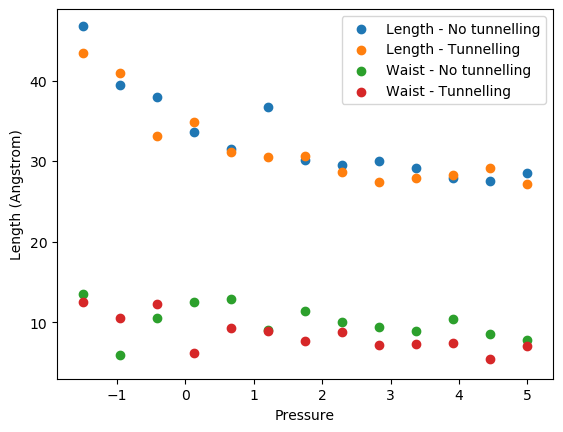

In [94]:
plt.scatter(P_list_notunn, len_list_notunn, label='Length - No tunnelling')
plt.scatter(P_list_tunn, len_list_tunn, label='Length - Tunnelling')
plt.scatter(P_list_notunn, waist_list_notunn, label='Waist - No tunnelling')
plt.scatter(P_list_tunn, waist_list_tunn, label='Waist - Tunnelling')
plt.legend()
plt.xlabel('Pressure')
plt.ylabel('Length (Angstrom)')
plt.savefig('compare_Sizes.png')


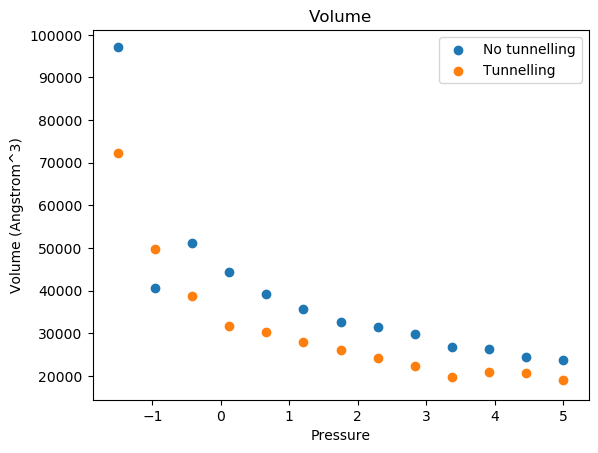

In [96]:
plt.scatter(P_list_notunn, vol_list_notunn, label='No tunnelling')
plt.scatter(P_list_tunn, vol_list_tunn, label='Tunnelling')
plt.legend()
plt.title('Volume')
plt.xlabel('Pressure')
plt.ylabel('Volume (Angstrom^3)')
plt.savefig('compare_Volume.png')


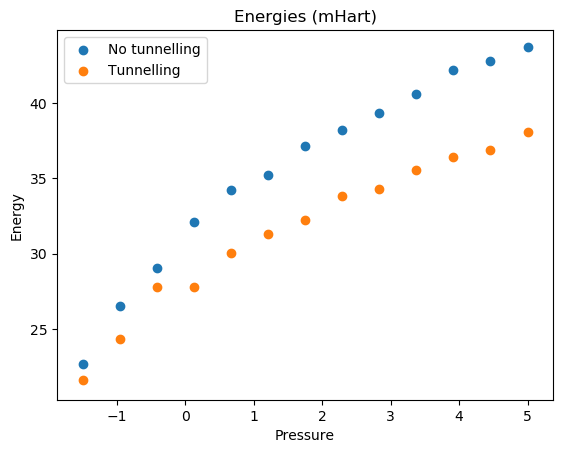

In [97]:
plt.scatter(P_list_notunn, E_fin_list_notunn, label='No tunnelling')
plt.scatter(P_list_tunn, E_fin_list_tunn, label='Tunnelling')
plt.legend()
plt.title('Energies (mHart)')
plt.xlabel('Pressure')
plt.ylabel('Energy')
plt.savefig('compare_Energy.png')

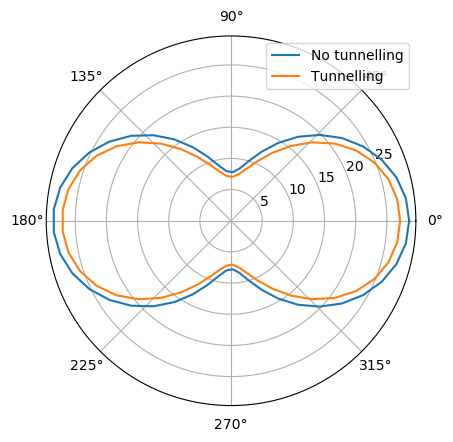

In [65]:
plot_bubble(a_fin_list_notunn[12, :])
plot_bubble(a_fin_list_tunn[12, :])
plt.legend(['No tunnelling', 'Tunnelling'])

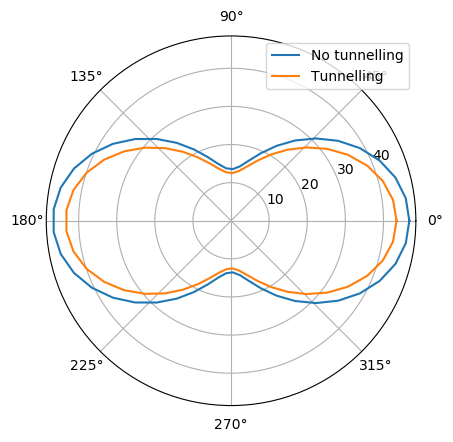

In [98]:
plot_bubble(a_fin_list_notunn[0, :])
plot_bubble(a_fin_list_tunn[0, :])
plt.legend(['No tunnelling', 'Tunnelling'])
plt.savefig('compare_Shapes.png')

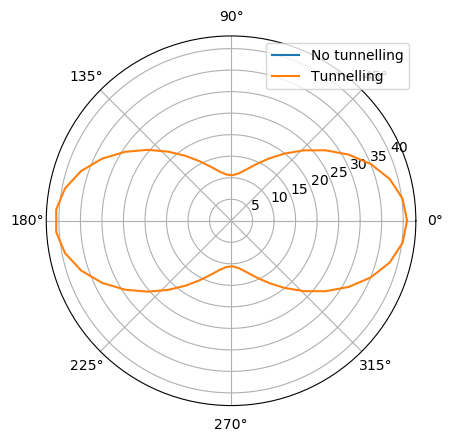

In [74]:
plot_bubble(a_fin_list_notunn[1, :])
plot_bubble(a_fin_list_tunn[1, :])
plt.legend(['No tunnelling', 'Tunnelling'])